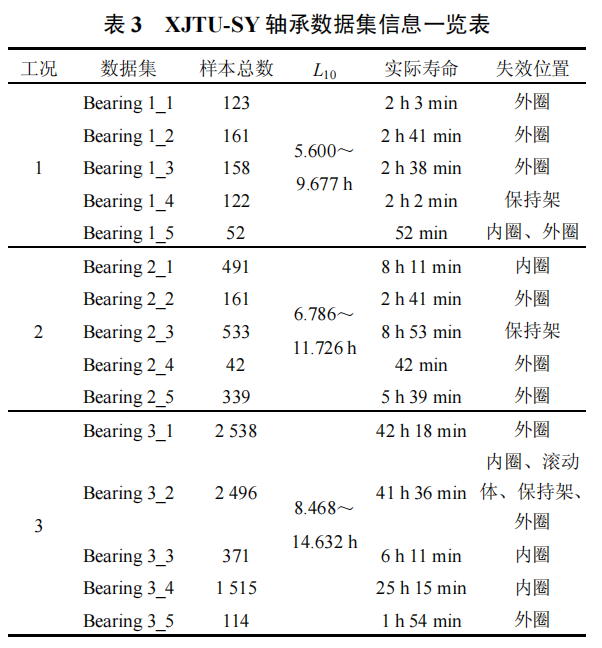

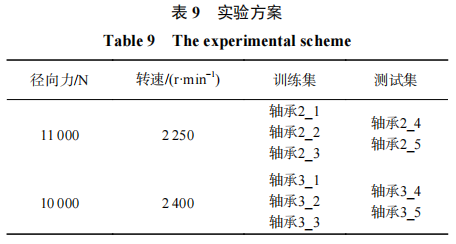

### 查看 Bearing1_1 文件下所有 csv文件形状

In [1]:
import os
import pandas as pd

# 指定包含 CSV 文件的目录路径
directory = './XJTU-SY_Bearing_Datasets/35Hz12kN/Bearing1_1'  # 注意实际目录路径

# 获取目录下所有 CSV 文件的文件名
csv_file_names = [f for f in os.listdir(directory) if f.endswith('.csv')]

# 将文件名排序，确保按照数字顺序读取
sorted_file_names = sorted(csv_file_names, key=lambda x: int(x.split('.')[0]))

# 逐个读取 CSV 文件并输出其形状
for file in sorted_file_names:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)
    # print(f'{file} 的形状是: {df.shape}')
    print(df.shape)

(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)
(32768, 2)

### 读取一个CSV 文件 看看数据格式和形状

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')

# 读取数据
original_data = pd.read_csv('./XJTU-SY_Bearing_Datasets/35Hz12kN/Bearing1_1/1.csv')
print(original_data.shape)
original_data.head()

(32768, 2)


,Horizontal_vibration_signals,Vertical_vibration_signals
0,-0.396395,-0.038672
1,-0.123107,-0.365901
2,0.988841,-0.583780
3,0.006676,-0.013411
4,-1.074386,0.087607


### 振动信号 可视化

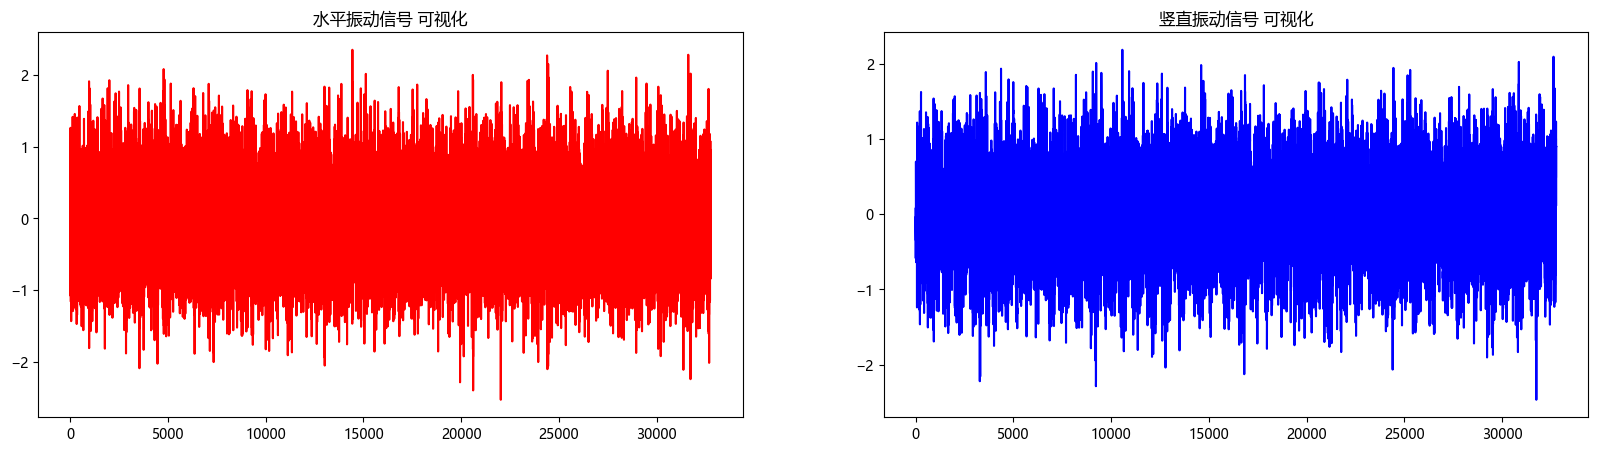

In [3]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(original_data.iloc[:,0], color='red')
plt.title('水平振动信号 可视化')
plt.subplot(122)
plt.plot(original_data.iloc[:,1], color='blue')
plt.title('竖直振动信号 可视化')
plt.show()

# 处理 数据集下面所有 CSV 文件

### 处理思路：
- 采用水平方向数据：
向的振动数据含有更多的退化信息,因此本文以
水平方向采集的数据作为研究对象（参考文献）
- 提取 12 个特征  
- 注意：这里我们更新后 只采用了12个特征, 可能与宣传的有出入(13 个特征)
- 这些提取的特征类型并不是必须、固定的, 可以灵活增减与替换, 我们也只是给出常见的特征, 作为参考！

In [4]:
# 定义处理函数
import pandas as pd
import os
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import entropy
import nolds
from scipy.fft import fft, fftfreq
from scipy.signal import welch, find_peaks
from scipy.stats import skew

def get_a_bearings_data(folder):
    ''' 
    获取某个工况下某个轴承的全部n个csv文件中的数据，返回numpy数组
    dp:bearings_x_x的folder
    return:folder下n个csv文件中的数据，shape:[n*32768,2]=[文件个数*采样点数，通道数]
    同时提取每个文件的统计特征：均值、方差、峰值
    '''
    # 获取目录下所有 CSV 文件的文件名
    csv_file_names = [f for f in os.listdir(folder) if f.endswith('.csv')]
    # 将文件名排序，确保按照数字顺序读取
    sorted_file_names = sorted(csv_file_names, key=lambda x: int(x.split('.')[0]))
    files = [os.path.join(folder,f) for f in sorted_file_names]

    h = []
    v = []
    features = []

    for f in files:
        data = pd.read_csv(f)
        
        h_data = data.iloc[:, 0].values
        v_data = data.iloc[:, 1].values
        
        h.append(h_data)
        v.append(v_data)
        
        # 提取信号  采用 水平方向数值信号
        signal = h_data
        # 将NumPy数组转换为列表
        signal = signal.tolist()
        # 计算每个文件的特征
        # 1. 峭度（Kurtosis）：衡量信号的尖锐程度，用于检测信号中的高频成分。
        kurt = kurtosis(signal)
        # 2. 分形值（Fractal Dimension）：衡量信号的自相似性和复杂度，用于分析信号的分形特征。
        fd = nolds.dfa(signal)
        # 3. 波形指标（Waveform Indicators）：峰值因子，用于分析信号的时域特征。
        peak_factor = np.max(np.abs(signal)) / np.sqrt(np.mean(np.square(signal)))
        # 4. 波形指标（Waveform Indicators）：脉冲因子，用于分析信号的时域特征。
        pulse_factor = np.max(np.abs(signal)) / np.mean(np.abs(signal))
        # 5. 波形指标（Waveform Indicators）：裕度因子，用于分析信号的时域特征。
        crest_factor = np.max(np.abs(signal)) / np.mean(np.sqrt(np.mean(np.square(signal))))
        # 6. 频谱指标（Spectral Indicators）：能量比值，用于分析信号的频域特征。
        # 计算信号的频谱
        sampling_rate = 25600  # 采样率  25.6 kHz
        freq, power_spectrum = welch(signal, fs=sampling_rate)
        # 计算峰值频率
        peak_freqs, _ = find_peaks(power_spectrum, height=np.mean(power_spectrum))  # 找到峰值
        # 计算能量比值
        total_energy = np.sum(power_spectrum)
        peak_energy = np.sum(power_spectrum[peak_freqs])
        energy_ratio = peak_energy / total_energy
        # 7. 频谱指标（Spectral Indicators）：谱线形指标，用于分析信号的频域特征。
        # 计算谱线形指标
        spectral_flatness = np.exp(np.mean(np.log(power_spectrum))) / (np.mean(power_spectrum))
        # 8. 统计特征（Statistical Features）：均值，用于描述信号的统计特性。
        mean = np.mean(signal)
        # 9. 统计特征（Statistical Features）：方差，用于描述信号的统计特性。
        variance = np.var(signal)
        # 10. 统计特征（Statistical Features）：偏度，用于描述信号的统计特性。
        skewness = skew(signal)
        # 11. 振动特征（Vibration Features）：包括峰值振动、有效值振动等，用于描述信号的振动特性。
        peak_vibration = np.max(np.abs(signal))
        # 12. 振动特征（Vibration Features）：包括峰值振动、有效值振动等，用于描述信号的振动特性。
        rms_vibration = np.sqrt(np.mean(np.square(signal)))
        feature_dict = {
            'Kurtosis': kurt,
            'Fractal Dimension': fd,
            'Peak factor': peak_factor,
            'Pulse factor': pulse_factor,
            'Crest factor': crest_factor,

            'Energy ratio': energy_ratio,
            'Spectral flatness': spectral_flatness,
            'Mean': mean,
            'Variance': variance,
            'Skewness': skewness,
            'Peak vibration': peak_vibration,
            'Rms vibration': rms_vibration
        }
        features.append(feature_dict)

    H = np.concatenate(h)
    V = np.concatenate(v)
    print(H.shape,V.shape)

    # 将特征存储为DataFrame
    features_df = pd.DataFrame(features)
    
    return np.stack([H, V], axis=-1), features_df

### Bearing1_1 处理

#### 读取 Bearing1_1  所有 csv 文件，形成一个完整的数据集

In [5]:
# 文件比较多，处理时间可能得 10-20 分钟不等，耐心等待运行完毕

Bearing1_1_all_data, Bearing1_1_features_df = get_a_bearings_data('./XJTU-SY_Bearing_Datasets/35Hz12kN/Bearing1_1/')
Bearing1_1_all_data.shape, Bearing1_1_features_df.shape

(4030464,) (4030464,)


((4030464, 2), (123, 12))

In [6]:
from joblib import dump, load

# 保存数据
dump(Bearing1_1_features_df, './预处理-中间数据/Bearing1_1_features_df') 
Bearing1_1_features_df.head()

,Kurtosis,Fractal Dimension,Peak factor,Pulse factor,Crest factor,Energy ratio,Spectral flatness,Mean,Variance,Skewness,Peak vibration,Rms vibration
0,0.071352,0.596723,4.486485,5.631549,4.486485,0.316064,0.568056,-0.007343,0.317918,-0.001797,2.529883,0.563890
1,0.137942,0.588284,6.150471,7.719625,6.150471,0.302163,0.570628,-0.007776,0.346952,-0.014991,3.623104,0.589078
2,0.246259,0.589283,5.634563,7.079562,5.634563,0.318574,0.589452,-0.001499,0.347551,0.022943,3.321779,0.589536
3,0.248190,0.587918,4.809554,6.065379,4.809554,0.298146,0.589467,0.006744,0.356691,0.013573,2.872622,0.597274
4,0.393918,0.586461,6.841896,8.624256,6.841896,0.290911,0.612054,-0.012305,0.365444,0.036585,4.136920,0.604645


In [7]:
# 保存数据
dump(Bearing1_1_all_data, './预处理-中间数据/Bearing1_1_all_data') 
Bearing1_1_all_data.shape

(4030464, 2)

Bearing1_1  可视化

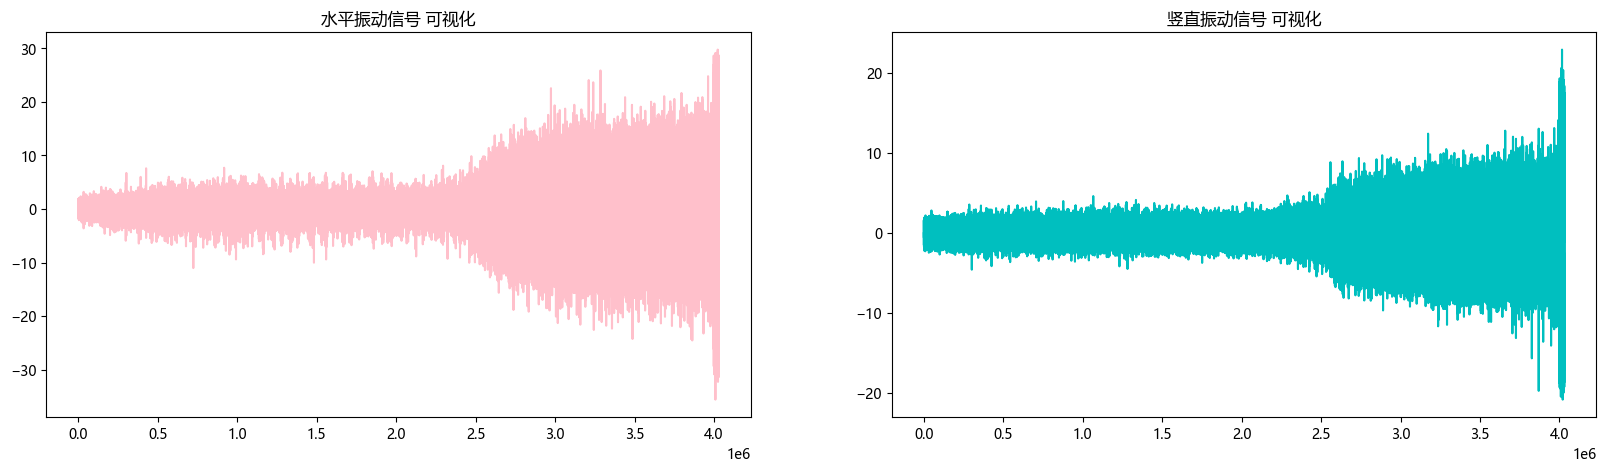

In [8]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(Bearing1_1_all_data[:,0], color='pink')
plt.title('水平振动信号 可视化')
plt.subplot(122)
plt.plot(Bearing1_1_all_data[:,1], color='c')
plt.title('竖直振动信号 可视化')
plt.show()

### Bearing1_2 处理

#### 读取 Bearing1_2  所有 csv 文件，形成一个完整的数据集

In [9]:
Bearing1_2_all_data, Bearing1_2_features_df = get_a_bearings_data('./XJTU-SY_Bearing_Datasets/35Hz12kN/Bearing1_2/')
Bearing1_2_all_data.shape, Bearing1_2_features_df.shape

(5275648,) (5275648,)


((5275648, 2), (161, 12))

In [10]:
# 保存数据
from joblib import dump, load

# 保存数据
dump(Bearing1_2_all_data, './预处理-中间数据/Bearing1_2_all_data') 
print(Bearing1_2_all_data.shape)

dump(Bearing1_2_features_df, './预处理-中间数据/Bearing1_2_features_df') 
Bearing1_2_features_df.head()

(5275648, 2)


,Kurtosis,Fractal Dimension,Peak factor,Pulse factor,Crest factor,Energy ratio,Spectral flatness,Mean,Variance,Skewness,Peak vibration,Rms vibration
0,0.932249,0.566005,6.972866,8.938807,6.972866,0.263090,0.503443,-0.004571,0.384003,0.080283,4.321063,0.619697
1,1.093941,0.568553,7.429372,9.562163,7.429372,0.254502,0.526302,-0.002833,0.373550,0.086606,4.540789,0.611194
2,1.162604,0.565824,7.182885,9.266917,7.182885,0.263956,0.511380,-0.002707,0.390715,0.056894,4.489863,0.625078
3,1.005726,0.573543,6.565154,8.424500,6.565154,0.262254,0.535207,0.000609,0.361695,0.044656,3.948355,0.601411
4,0.874407,0.575398,6.641121,8.502895,6.641121,0.285637,0.534402,-0.005780,0.352670,0.035913,3.944087,0.593889


Bearing1_2  可视化

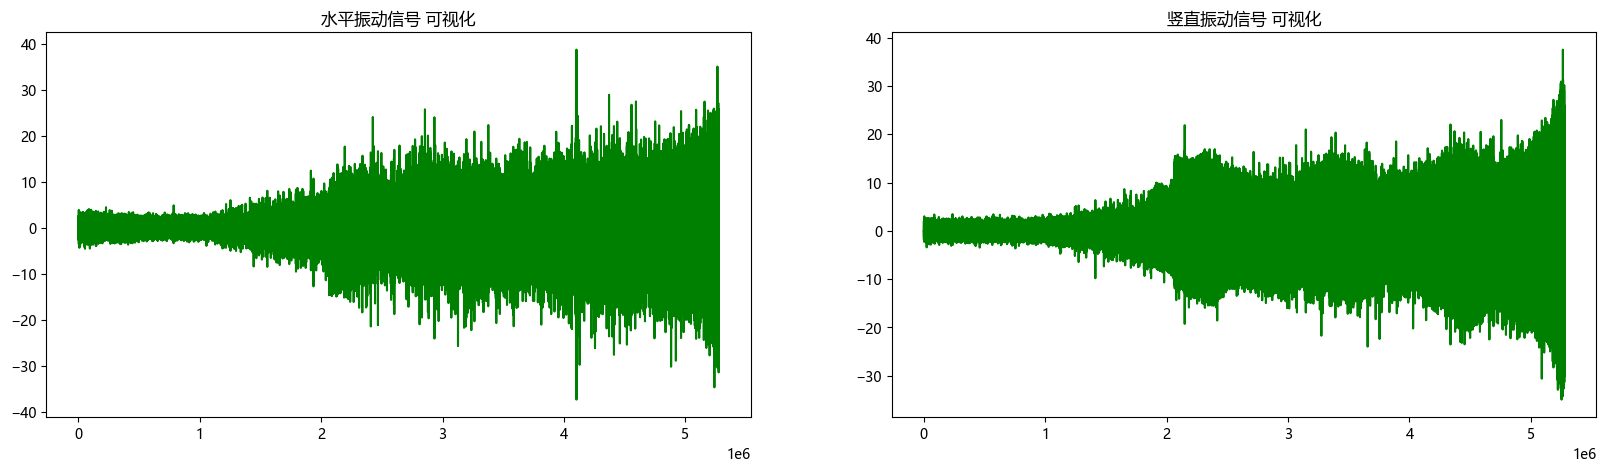

In [11]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(Bearing1_2_all_data[:,0], color='green')
plt.title('水平振动信号 可视化')
plt.subplot(122)
plt.plot(Bearing1_2_all_data[:,1], color='green')
plt.title('竖直振动信号 可视化')
plt.show()

### Bearing1_3 处理

#### 读取 Bearing1_3  所有 csv 文件，形成一个完整的数据集

In [12]:
Bearing1_3_all_data, Bearing1_3_features_df = get_a_bearings_data('./XJTU-SY_Bearing_Datasets/35Hz12kN/Bearing1_3/')
Bearing1_3_all_data.shape, Bearing1_3_features_df.shape

(5177344,) (5177344,)


((5177344, 2), (158, 12))

In [13]:
# 保存数据
from joblib import dump, load

dump(Bearing1_3_all_data, './预处理-中间数据/Bearing1_3_all_data') 
print(Bearing1_3_all_data.shape)

dump(Bearing1_3_features_df, './预处理-中间数据/Bearing1_3_features_df') 
Bearing1_3_features_df.head()

(5177344, 2)


,Kurtosis,Fractal Dimension,Peak factor,Pulse factor,Crest factor,Energy ratio,Spectral flatness,Mean,Variance,Skewness,Peak vibration,Rms vibration
0,-0.018922,0.609623,4.018646,5.029431,4.018646,0.259269,0.657274,-0.024847,0.244873,0.023867,1.991117,0.495470
1,0.034688,0.612596,4.341418,5.446060,4.341418,0.275181,0.668585,-0.009828,0.238535,0.005586,2.120781,0.488500
2,0.071580,0.607146,4.355396,5.476214,4.355396,0.247454,0.669986,-0.013385,0.246402,0.021185,2.162755,0.496569
3,0.011665,0.607159,4.285077,5.367199,4.285077,0.268315,0.664220,-0.005333,0.247482,0.003606,2.131844,0.497504
4,0.008824,0.603567,3.929223,4.923679,3.929223,0.262756,0.672394,-0.011985,0.259410,0.019776,2.001798,0.509464


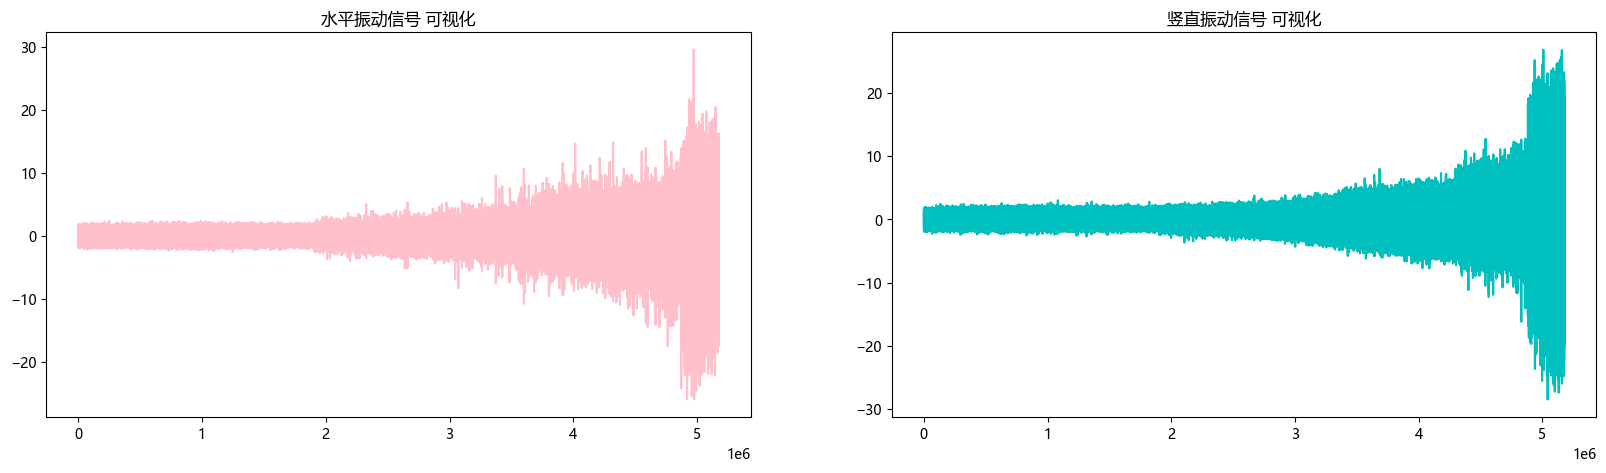

In [15]:
# 可视化
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(Bearing1_3_all_data[:,0], color='pink')
plt.title('水平振动信号 可视化')
plt.subplot(122)
plt.plot(Bearing1_3_all_data[:,1], color='c')
plt.title('竖直振动信号 可视化')
plt.show()

# 预测处理思路：
- 用Bearing1_1、Bearing1_2 来做训练， 
- Bearing1_3 来做测试！

处理思路：
利用处理好的特征指标，结合剩余寿命标签，来制作新的数据集

### 之前为什么 要保存 “预处理-中间数据” 呢？ 这里可以看出来，每次运行前面的预处理代码，可能会耗费大量的时间，保存这种预处理的中间结果，可以更方便的对预处理后的特征数据进行读取操作！！！

In [16]:
import os
import pandas as pd
import re
from joblib import dump, load



# 加载数据集
# 健康指标
Bearing1_1_features_df = load('./预处理-中间数据/Bearing1_1_features_df')
Bearing1_2_features_df = load('./预处理-中间数据/Bearing1_2_features_df')
Bearing1_3_features_df = load('./预处理-中间数据/Bearing1_3_features_df')

# 该目录下 样本实际寿命 
Bearing1_1_total_rul = Bearing1_1_features_df.shape[0]
Bearing1_2_total_rul = Bearing1_2_features_df.shape[0]
Bearing1_3_total_rul = Bearing1_3_features_df.shape[0]
print(Bearing1_1_total_rul, Bearing1_2_total_rul, Bearing1_3_total_rul)


# 记录已经使用的 时间
used_time_list1 = []
used_time_list2 = []
used_time_list3 = []

# 剩余寿命
data_rul_1 = []
data_rul_2 = []
data_rul_3 = []

# 处理 Bearing1_1_features_df 
# 遍历文件名从1到total_rul
for i in range(1, Bearing1_1_total_rul+1):
    # print(i)
    # 已经使用的时间
    used_time1 = i / Bearing1_1_total_rul
    used_time_list1.append(used_time1)

    # 计算 RUL
    rul = (Bearing1_1_total_rul- i)/Bearing1_1_total_rul
    data_rul_1.append(rul)

Bearing1_1_features_df['used_time'] = used_time_list1
Bearing1_1_features_df['rul'] = data_rul_1

# 处理 Bearing1_2_features_df 
# 遍历文件名从1到total_rul
for i in range(1, Bearing1_2_total_rul+1):
    # print(i)
    # 已经使用的时间
    used_time2 = i / Bearing1_2_total_rul
    used_time_list2.append(used_time2)

    # 计算 RUL
    rul = (Bearing1_2_total_rul- i)/Bearing1_2_total_rul
    data_rul_2.append(rul)

Bearing1_2_features_df['used_time'] = used_time_list2
Bearing1_2_features_df['rul'] = data_rul_2

# 处理 Bearing1_3_features_df 
# 遍历文件名从1到total_rul
for i in range(1, Bearing1_3_total_rul+1):
    # print(i)
    # 已经使用的时间
    used_time3 = i / Bearing1_3_total_rul
    used_time_list3.append(used_time3)

    # 计算 RUL
    rul = (Bearing1_3_total_rul- i)/Bearing1_3_total_rul
    data_rul_3.append(rul)

Bearing1_3_features_df['used_time'] = used_time_list3
Bearing1_3_features_df['rul'] = data_rul_3


print(Bearing1_1_features_df.shape)
print(Bearing1_2_features_df.shape)
print(Bearing1_3_features_df.shape)
Bearing1_3_features_df.head()

123 161 158
(123, 14)
(161, 14)
(158, 14)


,Kurtosis,Fractal Dimension,Peak factor,Pulse factor,Crest factor,Energy ratio,Spectral flatness,Mean,Variance,Skewness,Peak vibration,Rms vibration,used_time,rul
0,-0.018922,0.609623,4.018646,5.029431,4.018646,0.259269,0.657274,-0.024847,0.244873,0.023867,1.991117,0.495470,0.006329,0.993671
1,0.034688,0.612596,4.341418,5.446060,4.341418,0.275181,0.668585,-0.009828,0.238535,0.005586,2.120781,0.488500,0.012658,0.987342
2,0.071580,0.607146,4.355396,5.476214,4.355396,0.247454,0.669986,-0.013385,0.246402,0.021185,2.162755,0.496569,0.018987,0.981013
3,0.011665,0.607159,4.285077,5.367199,4.285077,0.268315,0.664220,-0.005333,0.247482,0.003606,2.131844,0.497504,0.025316,0.974684
4,0.008824,0.603567,3.929223,4.923679,3.929223,0.262756,0.672394,-0.011985,0.259410,0.019776,2.001798,0.509464,0.031646,0.968354


In [17]:
# 保存数据
Bearing1_1_features_df.to_csv('samples_data_Bearing1_1.csv', index=False)
Bearing1_2_features_df.to_csv('samples_data_Bearing1_2.csv', index=False)
Bearing1_3_features_df.to_csv('samples_data_Bearing1_3.csv', index=False)